# testing the signal analysis window...

In [1]:
from nftools import guis
import pylsl
import time
import numpy as np
import mne, re
from multiprocessing import Process
import dynarray
from datetime import datetime

In [2]:
%matplotlib qt  
# %gui qt
import warnings; warnings.filterwarnings('ignore') 

In [3]:
data_file = '/home/johan/nf/nf-rtime/Projects_Templates/3_RTMRICWL/trio2_eoec_outside_before.set'
raw = mne.io.read_raw_eeglab(data_file).resample(500)
raw_scaling = [item['cal'] for item in raw.info['chs']]

In [4]:
# raw.plot(scalings='auto');

In [8]:
# we need to transpose data, and then we can for-loop over it like so (extensively verbose):
def send_it(data_file):

    import mne
    # data_file = '/home/johan/nf/nf-rtime/Projects_Templates/3_RTMRICWL/trial_data_for_mri_cwl_development.set'

    raw = mne.io.read_raw_eeglab(data_file).resample(500)
    raw_scaling = [item['cal'] for item in raw.info['chs']]
    sfreq=raw.info['sfreq']
    
    print(raw)
    # create info for our purposes:
    info = pylsl.StreamInfo('Playback-3', 'EEG', len(raw.ch_names), raw.info['sfreq'], 'float32', 'someidentifier123')

    chns = info.desc().append_child("channels")
    for label in raw.ch_names:
        ch = chns.append_child("channel")
        ch.append_child_value("label", label)
        ch.append_child_value("unit", "microvolts")
        ch.append_child_value("type", "EEG")

    outlet = pylsl.StreamOutlet(info)

    # time_to_send_new_data_point = time.time()
    # time_to_wait_between_sending_data_points = 1/sfreq

    begin_time = time.time()
    current_time = 0.0
    all_data = raw.get_data().T / raw_scaling

    inds_sent = np.zeros(raw.last_samp+1, dtype=bool)
    while current_time < raw.last_samp/raw.info['sfreq']:

        inds_current = raw.times < current_time
        bool_slice = inds_current & ~inds_sent
        if bool_slice.any():
            b=np.min(np.where(bool_slice)[0])
            e=np.max(np.where(bool_slice)[0])+1


            stamp = pylsl.local_clock()-0.125
            outlet.push_chunk(all_data[b:e,:].tolist(), stamp)
            inds_sent = inds_sent | inds_current

            no_data_time=0

        time.sleep(0.1)
        current_time = time.time() - begin_time

    print('We are done sending this data')
    del(outlet)
        


In [9]:
p=Process(target=send_it, args=(data_file, ))

In [10]:
p.start()

<RawEEGLAB  |  trio2_eoec_outside_before.set, n_channels x n_times : 32 x 144870 (289.7 sec), ~35.5 MB, data loaded>
We are done sending this data


In [8]:
# prints out which streams are currently available
[ pylsl.stream_inlet(s).info().name() for s in pylsl.resolve_streams() ]

['Playback-3']

In [9]:
# which stream on  the network to read from?
stream_name = 'Playback-3'

# try grabbing all the information from that stream:
data_stream=pylsl.resolve_byprop("name", stream_name, timeout=5.0)
if data_stream:
    data_inlet=pylsl.stream_inlet(data_stream[0], max_buflen=10)
    stream_info = data_inlet.info()
    stream_Fs = stream_info.nominal_srate()
    stream_xml = stream_info.desc()
    chans_xml = stream_xml.child("channels")
    chan_xml_list = []
    ch = chans_xml.child("channel")
    while ch.name() == "channel":
        chan_xml_list.append(ch)
        ch = ch.next_sibling("channel")
    channel_names = [ch_xml.child_value("label") for ch_xml in chan_xml_list]
    data_inlet_dt = data_inlet.time_correction(timeout=5.0)
    sampling_freq = data_stream[0].nominal_srate()
    print('name = %s' % data_stream[0].name())
    print('sampling_freq = %d' % sampling_freq)
    print('channel_count = %d' % data_stream[0].channel_count())
    print('channel_format = %d' % data_stream[0].channel_format())
else:
    raise Exception('No Data Stream Found - Is your EEG Cap running?')

name = Playback-3
sampling_freq = 500
channel_count = 32
channel_format = 1


In [15]:
# clear EEG Data buffer

# we put the incoming data in here:
np_eo = dynarray.DynamicArray((None, len(channel_names)))

# we open up the window in which we visualize data
w=guis.AcquireData(sampling_freq, channel_names)

# before we start, pull everything from the buffer (empty it)
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 
    
# then start acquiring data as long as we want:
while w.RUNLOOP:

    if data_inlet.samples_available():
        
        chunk_data, chunk_times = data_inlet.pull_chunk(timeout=0.0) # grab from LSL

        np_eo.extend(chunk_data) # add to our list
        w.update(chunk_data) # update the GUI window
    else:
        w.update(None)

        

In [10]:
# and we make the MNE data file from it        
raw_eo = mne.io.RawArray(np.transpose(np_eo)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    'eeg', 
                                    None)
                       )

Creating RawArray with float64 data, n_channels=16, n_times=12075
    Range : 0 ... 12074 =      0.000 ...    96.592 secs
Ready.


In [15]:
raw_eo.filter(1, 35).plot();

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 413 samples (3.304 sec)



Opening raw data file First OpenBCI Recording!...
Isotrak not found
    Range : 0 ... 12074 =      0.000 ...    96.592 secs
Ready.


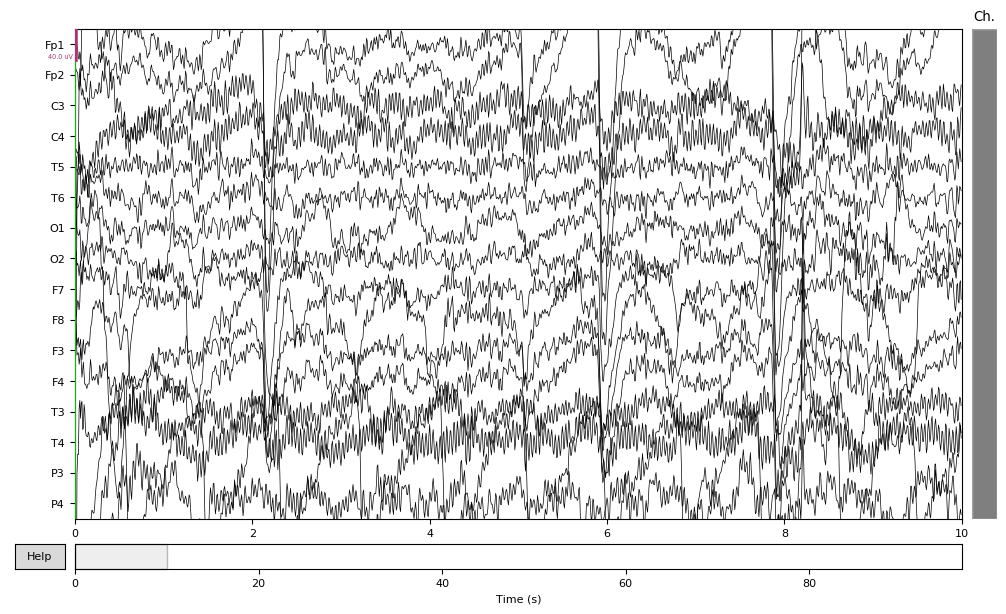

In [22]:
mne.io.read_raw_fif('First OpenBCI Recording!').plot()

In [10]:
raw_eo.save('First OpenBCI Recording!')

NameError: name 'raw_eo' is not defined

In [10]:
from callpyff import bcinetwork, bcixml
# bcinet = bcinetwork.BciNetwork('10.42.0.1', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')
bcinet = bcinetwork.BciNetwork('127.0.0.1', bcinetwork.FC_PORT, bcinetwork.GUI_PORT, 'bcixml')

In [11]:
global_std_band=5

In [12]:
# parameters to convert the filtered EEG signal to the stimulus
from nftools.nftools import signaltracking
track_for_eeg_stimuli = signaltracking.sending_to_nfstim(
    sampling_freq,
    thr=1.0 * global_std_band, 
    dur=0.20, 
    feedback_type='eeg', 
    max4audio=1.2, 
    bcinet=bcinet, 
    st_scaling=5 * global_std_band,
    verbose=False
)

# parameters to convert the filtered EMG signal to the stimulus
track_for_emg_stimuli = signaltracking.sending_to_nfstim(
    sampling_freq,
    thr=50 * global_std_band, 
    dur=0.15, 
    feedback_type='emg', 
    bcinet=bcinet, 
    st_scaling=100 * global_std_band,
    verbose=False
)

thr: 5.00, dur: 0.20
bcinet is passed on
thr: 250.00, dur: 0.15
bcinet is passed on


In [13]:
from pynfb.signal_processing.filters import (FilterSequence, 
                                             CFIRBandEnvelopeDetector, 
                                             ExponentialSmoother,
                                             SpatialFilter,
                                             ButterFilter,
                                             ButterBandEnvelopeDetector,
                                             ScalarButterFilter,
                                             MASmoother,
                                             FFTBandEnvelopeDetector,
                                            )

In [14]:
# Define Filter Sequence for NF

# Which channel do we select for the EEG?
rt_eeg_channels = ['Oz']
rt_eeg_channels_mask = np.where([ch in rt_eeg_channels for ch in channel_names], 1, 0)/len(rt_eeg_channels)

preprocess_filters_eeg = FilterSequence([
    SpatialFilter(rt_eeg_channels_mask),
    # ScalarButterFilter([1, None], sampling_freq),
])
envelope_filter_eeg = CFIRBandEnvelopeDetector([12, 15], sampling_freq, ExponentialSmoother(0.99))
envelope_filter_eeg2 = CFIRBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(150))
envelope_filter_classic = ButterBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(150))
# envelope_filter_classic_2 = ButterBandEnvelopeDetector([12, 15], sampling_freq, MASmoother(100))


# which channel for the EMG (Muscle)?
# rt_emg_channels = ['T3', 'T4'] # check if they're not in the bad channels..
# rt_emg_channels_mask = np.where([ch in rt_eeg_channels for ch in channel_names], 1, 0)/len(rt_eeg_channels)

#preprocess_filters_emg = FilterSequence([
#    SpatialFilter(rt_emg_channels_mask),
#    ScalarButterFilter([None, 50], sampling_freq),
#])
#envelope_filter_emg = CFIRBandEnvelopeDetector([50, 60], sampling_freq, ExponentialSmoother(0.9))
#
butter_visualization_1 = ButterFilter([12, 15], sampling_freq, 1)
butter_visualization_2 = ButterFilter([12, 15], sampling_freq, 1)
my_smoother_visualization = ExponentialSmoother(0.99)

In [15]:
# create our UI 'Experience' -- it can consist of 3 separate, movable windows (for now)
# same window as before + 2 other windows - 1 for interaction with stim/thresholds; 1 for looking
# at the analysis itself.
w_acquire = guis.AcquireData(sampling_freq, channel_names)
w_interaction = guis.NFChangeThresholds(track_for_eeg_stimuli, track_for_eeg_stimuli)
w_eeganalysis = guis.AnalyzeData(sampling_freq, ['EEG','env','thr','visual','audio'],track_for_eeg_stimuli)

In [16]:
# clear EEG Data buffer
data_inlet.pull_chunk()
while data_inlet.samples_available(): data_inlet.pull_chunk() 

In [17]:
# containers for data collection: 
time_nf = dynarray.DynamicArray()
data_nf = dynarray.DynamicArray((None, len(channel_names)))
data_analysis = dynarray.DynamicArray((None, 5))


# collect markers (for annotations)
stim_Annotations = mne.Annotations(0, 0, 'Start NF Stim')
# the GUI ones will be in w_analysis.GUI_Annotations


w_interaction.GUI_Annotations.append(time.time()-w_interaction.begin_time, 0, 'startloop')
w_acquire.RUNLOOP=True
acquisition_start = datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f')
while w_acquire.RUNLOOP:
    
    # check of the presentation gave any markers, and collect them:
    #while not marker_queue.empty():
    #    stim_time, stim_code = marker_queue.get()
    #    stim_Annotations.append(stim_time, 0, stim_code)
    
    # process the data:
    
    
    
    if not data_inlet.samples_available(): 
        w_acquire.update(None)
    else:
        chunk_data, chunk_times = data_inlet.pull_chunk() # grab from LSL

        # update window so we can see raw signals
        w_acquire.update(chunk_data) 
        
        # store in list for saving to disk (when done)
        time_nf.extend(chunk_times)
        data_nf.extend(chunk_data)
        
        
        # insert marker server
        # in any case, here we should just check a queue - and if there's contents - we grow our 
        # annotations array.
        
        
        # apply filters
        preprocessed_eeg = preprocess_filters_eeg.apply(chunk_data)
        
        envelope_eeg = envelope_filter_eeg.apply(preprocessed_eeg)
        envelope_eeg2 = envelope_filter_eeg2.apply(preprocessed_eeg)
        envelope_classic = envelope_filter_classic.apply(preprocessed_eeg)

        # preprocessed_emg = preprocess_filters_emg.apply(chunk_data)
        # envelope_emg = envelope_filter_emg.apply(preprocessed_emg)
        
        
        
        visual_markers_eeg, audio_markers_eeg = track_for_eeg_stimuli.check_above_threshold(envelope_eeg2)  # sends markers (should be fast)
        track_for_eeg_stimuli.send_data_signal(envelope_eeg2) # sends the signal (should also be fast!)
        # query the threshold
        # query the duration
        
        # visual_markers_emg, audio_markers_emg = track_for_emg_stimuli.check_above_threshold(envelope_classic)  # sends markers (should be fast)
        # track_for_emg_stimuli.send_data_signal(envelope_classic) # sends the signal (should also be fast!)

        # we should also pass on the track_for_eeg_stimuli and track_for_emg_stimuli to the GUI, as well
        # as the function of the buttons that they press (lambda functions)
        # so we know in our gui what is happening
        
        # make a matrix to put into the w_analysis...
        analysis_names = ('classic', 'cFIR', 'thr', 'vmarker', 'amarker')
        analysis_data = np.vstack((
            # envelope_classic,
            np.abs(butter_visualization_1.apply(preprocessed_eeg[:, None])[:, 0]),
            # my_smoother_visualization.apply(np.abs(butter_visualization.apply(preprocessed_eeg))),
            # my_smoother_visualization.apply(np.abs(butter_visualization_2.apply(preprocessed_eeg[:, None])[:, 0])),
            # envelope_eeg,
            envelope_eeg2,
            track_for_eeg_stimuli.thr * np.ones(preprocessed_eeg.shape),
            visual_markers_eeg,
            audio_markers_eeg,

        )).T
        
        data_analysis.extend(analysis_data)  # store it for later conversion
        w_eeganalysis.update(analysis_data)  # put it onto the screen (but keep our on/off button...)
        
        
        # collect the events that we generate - they are in w_analysis.MNEAnnotations
        

        
    # after the loop is done -- we can close the windows (optionally) (or with code)
    # and convert signals + analyzed signals into one MNE struct.
    # best way would be to inspect a short recording and deal with allthe issues
    # se also: w_analysis.GUI_Annotations

In [18]:
# and we make the MNE data file from it
analysis_names = ('classic', 'cFIR', 'thr', 'vmarker', 'amarker')
raw_analyzed = mne.io.RawArray(np.transpose(np.array(data_analysis) * [1E-6, 1E-6, 1E-6, 1, 1]),
                        mne.create_info(analysis_names, 
                                    sampling_freq, 
                                    ['eeg','eeg','eeg','stim','stim'], 
                                    None)
                       )

analyzed_filename = 'analyzed.fif'

Creating RawArray with float64 data, n_channels=5, n_times=10108
    Range : 0 ... 10107 =      0.000 ...    20.214 secs
Ready.


In [19]:
annots = w_interaction.GUI_Annotations

In [45]:
annots[list(map(lambda d: re.match('start.*', d) is not None, annots.description))]

<Annotations  |  12 segments : start the GUI (1), starteeg_thr 5 (2), starteeg_dur 0.2 (2)..., orig_time : 2020-03-14 09:21:21.452665>

In [67]:
# handle annotations, since w_interaction starts before data acquisition
annots = w_interaction.GUI_Annotations.copy()
tdelta = datetime.strptime(acquisition_start,'%Y-%m-%d %H:%M:%S.%f').timestamp() - annots.orig_time
annots.onset -= tdelta
annots.orig_time=None

starting_annots = annots[list(map(lambda d: re.match('start.*', d) is not None, annots.description))]
starting_annots.onset = 0.1*np.ones(len(starting_annots))
starting_annots.orig_time = None

raw_analyzed.set_annotations(starting_annots + annots)


<RawArray  |  None, n_channels x n_times : 5 x 10108 (20.2 sec), ~409 kB, data loaded>

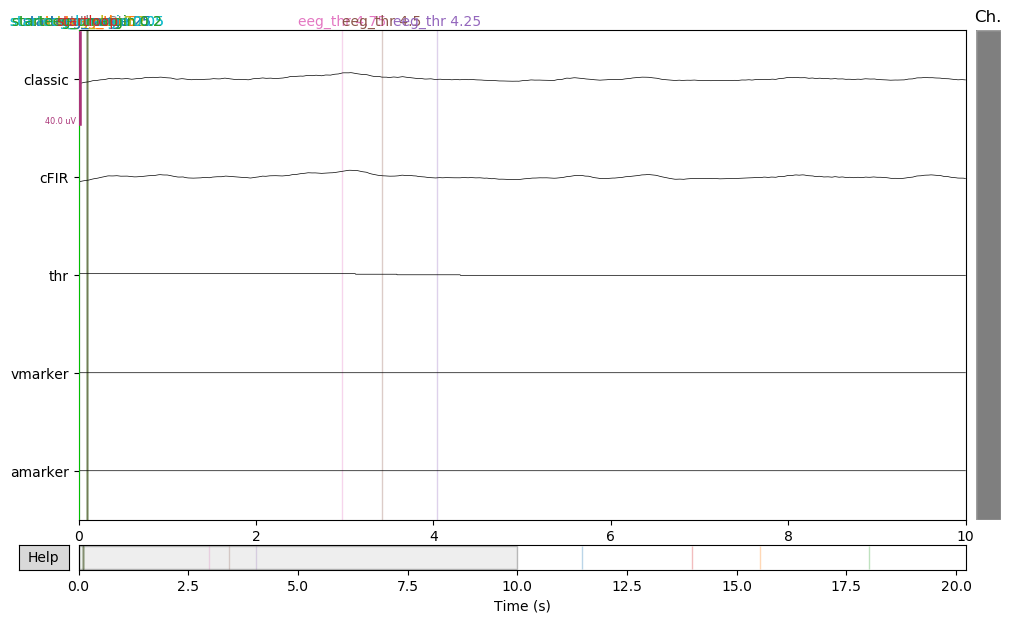

In [68]:
raw_analyzed.plot()

In [25]:
startomg_annots.onset
for annot in annots:
    if annot['onset'] < 0:
        annot['onset'] = 0.1
annots.orig_time = None
raw_analyzed.set_annotations(annots)        


# raw_analyzed.set_meas_date(acquisition_start)
raw_analyzed.save(analyzed_filename, overwrite=True)

Overwriting existing file.
Writing /home/johan/nf/nf-rtime/Tutorials/analyzed.fif
Closing /home/johan/nf/nf-rtime/Tutorials/analyzed.fif [done]


In [50]:
annots[annots.onset < 0].onset += 10

In [40]:
raw_data = mne.io.RawArray(np.transpose(data_nf)*1E-6,
                        mne.create_info(channel_names, 
                                    sampling_freq, 
                                    'eeg', 
                                    None),
                           verbose='INFO'
                       )
data_filename = 'data.fif'
raw_data.save(data_filename, overwrite=True)

Creating RawArray with float64 data, n_channels=32, n_times=13871
    Range : 0 ... 13870 =      0.000 ...    27.740 secs
Ready.
Overwriting existing file.
Writing /home/johan/nf/nf-rtime/Tutorials/data.fif
Closing /home/johan/nf/nf-rtime/Tutorials/data.fif [done]


**Markers**; the Interaction GUI makes several annotations
The markers pertaining to audio/visual, they are in the traces (for analysis); the markers coming from the Stimulus, they are (also) with annotations.

in terms of timing:
- gui -- annotations, relative (I guess) markers -- need to figure out timing
- stimulus PC -- annotations, relative markers
- analysis -- directly linked to the traces

In [22]:
raw_analyzed.annotations.

<Annotations  |  11 segments : startloop (1), eeg_thr 4.75 (1), eeg_thr 4.5 (1)..., orig_time : None>

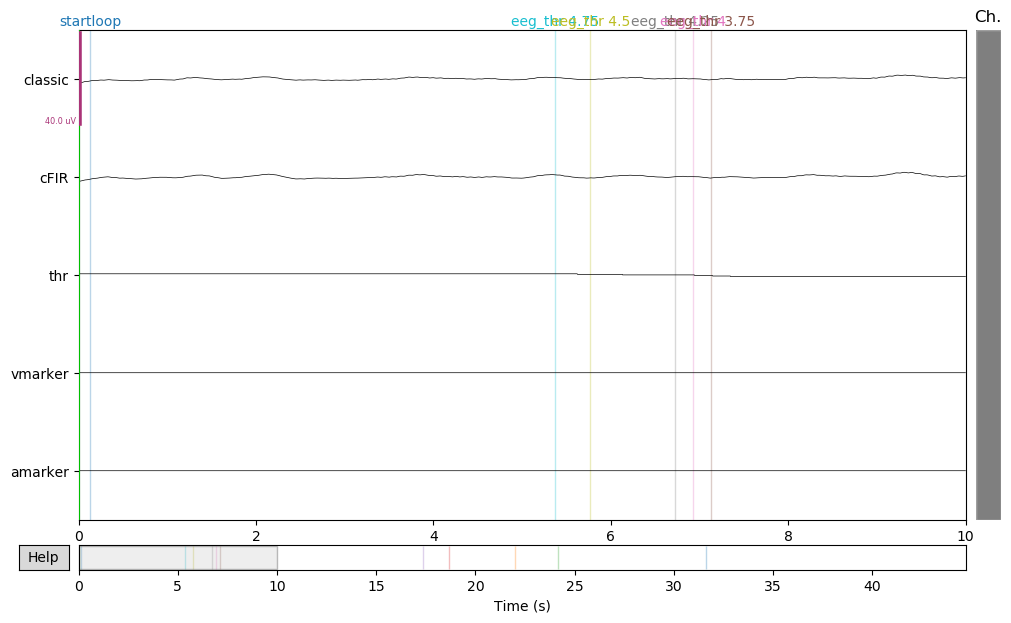

In [20]:
raw_analyzed.plot()

In [26]:
w_interaction.GUI_Annotations.onset

array([0.00000000e+00, 7.60960579e-03, 8.10122490e-03, 8.61334801e-03,
       9.30428505e-03, 9.84930992e-03, 1.09367371e-02, 1.12118721e-02,
       1.15349293e-02, 1.17297173e-02, 1.19068623e-02, 1.80302665e+01,
       2.02702591e+01, 4.64723859e+01, 5.72860336e+01, 5.81263733e+01,
       5.88791380e+01, 9.69318848e+01, 9.72664654e+01, 9.76390080e+01,
       9.79555888e+01, 1.15927522e+02, 1.19528189e+02, 1.27608989e+02,
       1.28149634e+02, 1.29202847e+02, 1.30632641e+02, 1.32247317e+02,
       1.41728235e+02, 1.43613005e+02, 1.43922191e+02, 2.39915317e+02,
       2.41690236e+02, 2.41916959e+02, 2.42114452e+02, 2.42330279e+02,
       2.42529921e+02, 2.42721440e+02, 2.42919930e+02, 2.43197610e+02,
       2.50647672e+02, 2.55537004e+02, 2.63975041e+02, 2.65092566e+02,
       2.66069820e+02])

In [29]:
w_interaction.GUI_Annotations[0]

OrderedDict([('onset', 0.0),
             ('duration', 0.0),
             ('description', 'start the GUI'),
             ('orig_time', None)])

In [34]:
raw.first_samp

0

In [36]:
raw.info

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | F3, F4, C3, C4, P3, P4, PO3, PO4, FC5, ...
    chs : list | 32 items (EEG: 32)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 32 items (32 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : NoneType | unspecified
    nchan : int | 32
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_n

In [37]:
mne.events_from_annotations?

Signature:
mne.events_from_annotations(
    raw,
    event_id='auto',
    regexp='^(?![Bb][Aa][Dd]|[Ee][Dd][Gg][Ee]).*$',
    use_rounding=True,
    chunk_duration=None,
    verbose=None,
)
Docstring:
Get events and event_id from an Annotations object.

Parameters
----------
raw : instance of Raw
    The raw data for which Annotations are defined.
event_id : dict | callable | None | 'auto'
    Can be:

    - **dict**: map descriptions (keys) to integer event codes (values).
      Only the descriptions present will be mapped, others will be ignored.
    - **callable**: must take a string input and returns an integer event
      code or None to ignore it.
    - **None**: Map descriptions to unique integer values based on their
      ``sorted`` order.
    - **'auto' (default)**: prefer a raw-format-specific parser:

      - Brainvision: map stimulus events to their integer part; response
        events to integer part + 1000; optic events to integer part + 2000;
        'SyncStatus/Sync O